In [1]:
city='Beijing'
city_cn='北京'

# Developer Salary in Beijing 北京程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [71]:
import pandas as pd
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
import scipy.stats as stats
import numpy as np
import weighted
%matplotlib inline

In [72]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _201904v2 where monthly_salary>0 and monthly_salary<180000", con=conn)
conn.close()

In [73]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [74]:
#del data['publish_date']
#del data['published_on_weekend']
#del data['title']
#del data['title']
#del data['company_title']
#del data['company_description']
#del data['job_description']
#del data['job_id']

In [78]:
data=data.sort_values(by='headcount', ascending=False)
data.head()

,job_id,monthly_salary,headcount,title,career,city,company_description,company_size,company_title,company_type,ageism,db_Apache_Hive,db_CouchBase,db_CouchDB,db_DB2,db_DynamoDB,db_Elasticsearch,db_FileMaker,db_Firebase,db_Firebird,db_Hbase,db_Informix,db_Ingres,db_MariaDB,db_Memcached,db_MongoDB,db_MySQL,db_Neo4j,db_Netezza,db_Oracle,db_PostgreSQL,db_Redis,db_Riak,db_SAP_HANA,db_SQL_Server,db_SQLite,db_Solr,db_Splunk,db_Sybase,db_Teradata,db_dBase,edu,english,experience,expert_adas,expert_blockchain,expert_embed,expert_expert,expert_gis,_996_yes,_996_no,industry,japanese,job_description,job_summary,job_tags,phone_android,phone_app,phone_iso,pl_c_sharp,pl_cpp,pl_delphi,pl_go,pl_haskell,pl_java,pl_javascript,pl_julia,pl_kotlin,pl_lua,pl_matlab,pl_objective_c,pl_perl,pl_php,pl_python,pl_ruby,pl_rust,pl_scrala,pl_swift,pl_typescript,pl_vba,pl_visual_basic,publish_date,published_on_weekend,tag_baby_care,tag_five_insurance,tag_flexible,tag_no_overtime,tag_rest_one_day,tag_rest_two_days,tag_stock
25849,110969579,12500.0,200,JAVA开发工程师（2019届应届毕业生）,一般程序员,guangzhou,广州汇智通信技术有限公司是专业从事国家特殊通信系统研制工作的大型国有控股混合所有制企业。公司...,1000-5000,广州汇智通信技术有限公司,国企,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,本科,False,no,False,False,False,False,False,True,False,computer,False,广州汇智通信技术有限公司 ...,广州|无工作经验|本科|招200人|03-31发布,"五险一金,补充医疗保险,补充公积金,交通补贴,年终奖金,绩效奖金,通讯补贴,定期体检,餐饮补贴",False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-03-31,True,False,True,False,False,False,False,False
15903,108834444,15000.0,150,Java开发工程师,一般程序员,beijing,大连华信计算机技术股份有限公司（简称大连华信）是一家面向全球客户提供领先的应用软件产品、信息...,5000-10000,大连华信计算机技术股份有限公司,合资,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,本科,False,5_10,False,False,False,False,False,False,False,computer,False,1、5年以上java开发工作经验。2、有丰富研发经验；深入理解SpringCloud、spr...,北京-朝阳区|5-7年经验|本科|招150人|03-29发布,"五险一金,补充医疗保险,定期体检,年终奖金",False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2019-03-29,False,False,True,False,False,False,False,False
30861,112071980,12500.0,150,Java研发工程师（WEB）-广州,一般程序员,guangzhou,美亚柏科公司简介厦门市美亚柏科信息股份有限公司（股票简称：美亚柏科，股票代码：300188）...,1000-5000,厦门市美亚柏科信息股份有限公司,民营公司,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,本科,False,3_5,False,False,False,False,False,False,False,computer,False,工作职责:1)\t基于海量数据的WEB应用研发。2)\t数据可视化设计与实现。3)\t根据业...,广州-海珠区|3-4年经验|本科|招150人|04-01发布,"五险一金,免费班车,员工旅游,交通补贴,餐饮补贴,年终奖金,弹性工作,股票期权",False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-04-01,False,False,True,True,False,False,False,True
25365,110864187,7000.0,150,初级测试工程师,一般程序员,beijing,···,50-150,北京领航绿色科技有限公司,民营公司,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,大专,False,no,False,False,False,False,False,False,True,finance,False,工作职业一;1.根据软件测试计划和测试方案，设计测试数据和测试用例。 ...,北京-朝阳区|无工作经验|大专|招150人|03-26发布,"五险一金,免费班车,交通补贴,餐饮补贴,绩效奖金",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-03-26,False,False,True,False,False,False,False,False
30797,112055617,8000.0,100,Java开发工程师,一般程序员,guangzhou,贵州四方合创科技有限公司主营业务是围绕运营商，面向政府、企业用户的信息服务需求，提供可运营的...,50-150,贵州四方合创科技有限公司,民营公司,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [79]:
def pd_weighted_mean(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [116]:
salary_mean=weighted.weighted_mean(data.monthly_salary.values, data.headcount.values)
q=weighted.weighted_quantile(data.monthly_salary.values,[0.025,0.25,0.5,0.75,0.975], data.headcount.values)
q

array([ 4250., 10000., 12500., 18000., 35000.])

In [120]:
print('2019年{}程序员的平均工资为{:.0f}元，工资中位数为{:.0f}元，其中95%的人的工资位于{:.0f}到{:.0f}元之间。'
      .format(city_cn,salary_mean, q[2], q[0], q[4]))

2019年北京程序员的平均工资为15314元，工资中位数为12500元，其中95%的人的工资位于4250到35000元之间。


In [121]:
print('In 2019, Developers in {} earn {:.0f} Yuan as average, '
      'the median is {:.0f} Yuan, 95% of them earn between {:.0f} and {:.0f} Yuan.'
      .format(city,salary_mean, q[2], q[0], q[4]))

In 2019, Developers in Beijing earn 15314 Yuan as average, the median is 12500 Yuan, 95% of them earn between 4250 and 35000 Yuan.


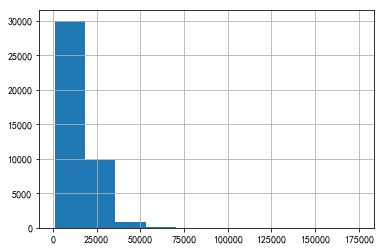

In [122]:
data.monthly_salary.hist()

It does not look like normal distribution.

In [123]:
from scipy import stats

In [124]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=32378.436582408962, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

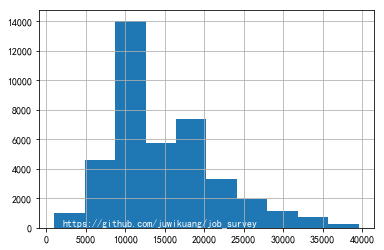

In [125]:
data[data.monthly_salary<40000].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(2000, 100), color='white')
plt.show()

## Role 角色

In [126]:
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [127]:
data_career = get_sub_stats_by_col(data,'career')
data_career.style.format({"salary_mean":"{:.0f}","salary_median":"{:.0f}","percentage":"{:.2%}"})

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
1,算法工程师,23013,5250,20000,62500,12885,9.76%
2,系统架构师,22952,6500,22500,45833.3,4764,3.61%
3,架构设计师,21308,4542.5,19000,50000,1877,1.42%
0,一般程序员,14009,4000,12500,30000,112534,85.21%


In [128]:
np.sum(data.monthly_salary * data.headcount) / data.headcount.sum()

15313.812534706447

In [129]:
data.headcount.sum()

132060

In [130]:
data.headcount.describe()

count    40761.000000
mean         3.239862
std          3.647367
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        200.000000
Name: headcount, dtype: float64

In [131]:
pd.options.display.max_columns=100
data.sort_values(by='headcount', ascending=False).head()

,job_id,monthly_salary,headcount,title,career,city,company_description,company_size,company_title,company_type,ageism,db_Apache_Hive,db_CouchBase,db_CouchDB,db_DB2,db_DynamoDB,db_Elasticsearch,db_FileMaker,db_Firebase,db_Firebird,db_Hbase,db_Informix,db_Ingres,db_MariaDB,db_Memcached,db_MongoDB,db_MySQL,db_Neo4j,db_Netezza,db_Oracle,db_PostgreSQL,db_Redis,db_Riak,db_SAP_HANA,db_SQL_Server,db_SQLite,db_Solr,db_Splunk,db_Sybase,db_Teradata,db_dBase,edu,english,experience,expert_adas,expert_blockchain,expert_embed,expert_expert,expert_gis,_996_yes,_996_no,industry,japanese,job_description,job_summary,job_tags,phone_android,phone_app,phone_iso,pl_c_sharp,pl_cpp,pl_delphi,pl_go,pl_haskell,pl_java,pl_javascript,pl_julia,pl_kotlin,pl_lua,pl_matlab,pl_objective_c,pl_perl,pl_php,pl_python,pl_ruby,pl_rust,pl_scrala,pl_swift,pl_typescript,pl_vba,pl_visual_basic,publish_date,published_on_weekend,tag_baby_care,tag_five_insurance,tag_flexible,tag_no_overtime,tag_rest_one_day,tag_rest_two_days,tag_stock
25849,110969579,12500.0,200,JAVA开发工程师（2019届应届毕业生）,一般程序员,guangzhou,广州汇智通信技术有限公司是专业从事国家特殊通信系统研制工作的大型国有控股混合所有制企业。公司...,1000-5000,广州汇智通信技术有限公司,国企,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,本科,False,no,False,False,False,False,False,True,False,computer,False,广州汇智通信技术有限公司 ...,广州|无工作经验|本科|招200人|03-31发布,"五险一金,补充医疗保险,补充公积金,交通补贴,年终奖金,绩效奖金,通讯补贴,定期体检,餐饮补贴",False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-03-31,True,False,True,False,False,False,False,False
30861,112071980,12500.0,150,Java研发工程师（WEB）-广州,一般程序员,guangzhou,美亚柏科公司简介厦门市美亚柏科信息股份有限公司（股票简称：美亚柏科，股票代码：300188）...,1000-5000,厦门市美亚柏科信息股份有限公司,民营公司,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,本科,False,3_5,False,False,False,False,False,False,False,computer,False,工作职责:1)\t基于海量数据的WEB应用研发。2)\t数据可视化设计与实现。3)\t根据业...,广州-海珠区|3-4年经验|本科|招150人|04-01发布,"五险一金,免费班车,员工旅游,交通补贴,餐饮补贴,年终奖金,弹性工作,股票期权",False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-04-01,False,False,True,True,False,False,False,True
25365,110864187,7000.0,150,初级测试工程师,一般程序员,beijing,···,50-150,北京领航绿色科技有限公司,民营公司,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,大专,False,no,False,False,False,False,False,False,True,finance,False,工作职业一;1.根据软件测试计划和测试方案，设计测试数据和测试用例。 ...,北京-朝阳区|无工作经验|大专|招150人|03-26发布,"五险一金,免费班车,交通补贴,餐饮补贴,绩效奖金",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019-03-26,False,False,True,False,False,False,False,False
15903,108834444,15000.0,150,Java开发工程师,一般程序员,beijing,大连华信计算机技术股份有限公司（简称大连华信）是一家面向全球客户提供领先的应用软件产品、信息...,5000-10000,大连华信计算机技术股份有限公司,合资,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,本科,False,5_10,False,False,False,False,False,False,False,computer,False,1、5年以上java开发工作经验。2、有丰富研发经验；深入理解SpringCloud、spr...,北京-朝阳区|5-7年经验|本科|招150人|03-29发布,"五险一金,补充医疗保险,定期体检,年终奖金",False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2019-03-29,False,False,True,False,False,False,False,False
30797,112055617,8000.0,100,Java开发工程师,一般程序员,guangzhou,贵州四方合创科技有限公司主营业务是围绕运营商，面向政府、企业用户的信息服务需求，提供可运营的...,50-150,贵州四方合创科技有限公司,民营公司,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

# 编程语言

In [132]:


def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(weighted.weighted_mean(values, weights))
        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
    {"salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}","percentage":"{:.2%}"})

In [133]:
data_pl=get_sub_stats_by_prefix(data,'pl_')
apply_style(data_pl)


rank,pl_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,haskell,29557,30833,7500,45000,32,0.02%
2,julia,26875,26875,17500,30000,4,0.00%
3,rust,23724,20000,7150,57046,183,0.10%
4,matlab,20174,18000,5250,45000,2961,1.58%
5,python,20126,17500,4500,45833,15747,8.39%
6,perl,19420,17500,5000,45000,1583,0.84%
7,go,19213,17500,6352,45000,15037,8.02%
8,lua,18769,17500,5250,42125,1266,0.67%
9,cpp,17772,15000,5000,41667,29675,15.82%
10,ruby,17722,17500,6175,35000,618,0.33%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [95]:
data_edu=get_sub_stats_by_col(data[data.edu.isin(['大专','本科','硕士','博士'])], 'edu')
apply_style(data_edu)

edu,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
博士,28191,12500,27321,55000,236,0.22%
硕士,22426,3750,20000,50000,4161,3.80%
本科,16265,4500,14583,37500,71774,65.63%
大专,12473,4500,12000,27500,33187,30.35%


In [96]:
salary_associate=data[data.edu=='大专'].monthly_salary
salary_bachelor=data[data.edu=='本科'].monthly_salary
salary_master=data[data.edu=='硕士'].monthly_salary
salary_phd=data[data.edu=='博士'].monthly_salary

In [97]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是12667，16633，22588，29686。中位数分别是12500， 15000，20000， 29000。


In [98]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=23.144740567704, pvalue=1.6545088803207718e-06)

In [99]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=595.5576201244492, pvalue=5.9379062255845094e-130)

In [100]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=1771.1009187651957, pvalue=0.0)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

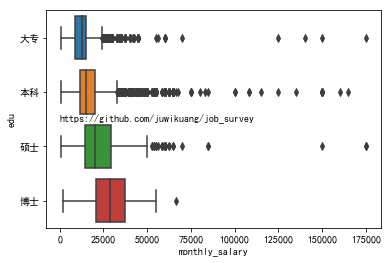

In [101]:

order=['大专','本科','硕士','博士']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [108]:
data_experience=get_sub_stats_by_col(data, 'experience')
apply_style(data_experience)

experience,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
10+,32065,12398,30000,54167,393,0.30%
5_10,21918,10500,20000,45000,16264,12.32%
3_5,16606,7500,15000,36296,38229,28.95%
no,13714,3000,12500,35000,39223,29.70%
1_3,12662,5250,11500,28018,37951,28.74%


In [109]:
salary_we_10=data[data.experience=='10+'].monthly_salary
salary_we_5_10=data[data.experience=='5_10'].monthly_salary
salary_we_3_5=data[data.experience=='3_5'].monthly_salary
salary_we_1_3=data[data.experience=='1_3'].monthly_salary
salary_we_no=data[data.experience=='no'].monthly_salary

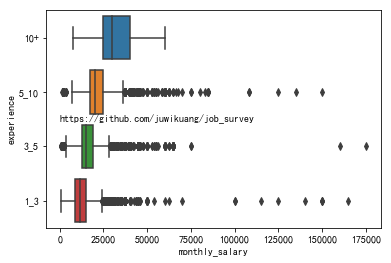

In [110]:

order=['10+','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [111]:
data_company_type=get_sub_stats_by_col(data,'company_type')
apply_style(data_company_type)

company_type,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
外资（欧美）,18898,4500,17500,45000,7795,5.90%
合资,16084,5250,14500,35417,12957,9.81%
事业单位,15778,4667,12500,29167,950,0.72%
外资（非欧美）,15025,3750,12500,35000,7577,5.74%
民营公司,14997,4250,12500,35000,92744,70.23%
外企代表处,14943,7000,12500,36425,73,0.06%
国企,14799,3750,12500,30000,9685,7.33%
非营利组织,10814,5929,10000,22308,123,0.09%
政府机关,7396,5339,7000,15635,156,0.12%


us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [112]:
data_company_size=get_sub_stats_by_col(data,'company_size')
apply_style(data_company_size)

company_size,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
10000+,20056,4500,17500,50000,5574,4.22%
500-1000人,17492,5250,15000,50531,13903,10.53%
1000-5000,16852,4000,15000,37500,16254,12.31%
5000-10000,15454,5327,14583,30000,3072,2.33%
,15330,3330,12500,50000,804,0.61%
150-500,15165,5250,12500,35000,29140,22.07%
50-150,14359,4000,12500,33333,40808,30.90%
50-,13587,3750,12500,30000,22505,17.04%


公司越大，工资越高

## 行业 Industry

In [113]:
data_industry=get_sub_stats_by_col(data,'industry')
apply_style(data_industry)

industry,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
finance,16558,5250,15000,35000,4580,3.47%
edu,15925,5644,12500,37500,8758,6.63%
service,15855,3975,14000,43229,870,0.66%
trade,15386,5000,13083,35000,7390,5.60%
computer,15300,4000,12500,35000,99456,75.31%
ads,15298,5000,12500,35000,1728,1.31%
medical,14570,4794,12500,30000,2667,2.02%
gov,14482,3750,12500,30896,1717,1.30%
logistic,14263,5000,12500,30000,1545,1.17%
realestate,13879,3750,12500,32629,1826,1.38%
